In [1]:
from copy import deepcopy

import interfere
import matplotlib.pyplot as plt
import numpy as np



SEED = 11
NOTEBOOK_RNG = np.random.default_rng(SEED)

# Noise and Forecast Error

This notebook explores how the addition of some stochasticity to a system helps with
forecasting but too much is a hinderance. It also investigates the interaction between
measurement noise and system noise.

In [2]:
def uniform_init_cond(min_x, max_x, dim, reps, rng=NOTEBOOK_RNG):
    """Generates initial conditions for dynamic models."""
    return [
        (max_x - min_x) * rng.random(dim) + min_x for i in range(reps)
    ]

### Lokta Voltera Model

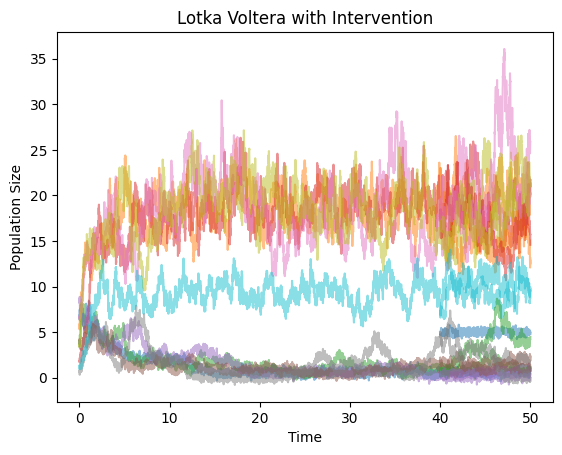

In [36]:
dim = 10
reps = 10

params = dict(
    model_type=interfere.dynamics.LotkaVolteraSDE,
    model_params={
        "growth_rates": 5 * NOTEBOOK_RNG.random(dim),
        "capacities": 20 * np.ones(dim),
        # A cycle and isolated node
        "interaction_mat": np.array([
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
            [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
        ]),
        "sigma": 0.3,
        "measurement_noise_std": 0.25 * np.ones(dim)},
    intervention_type=interfere.PerfectIntervention,
    intervention_params={"intervened_idxs": 0, "constants": 5.0},
    initial_conds=uniform_init_cond(0, 10, dim, reps),
    start_time=0, end_time=50, dt=0.01,
    rng = np.random.default_rng(SEED)
)


Xs, X_dos, t = interfere.generate_counterfactual_forecasts(**params)
sample_X, sample_X_do = Xs[2], X_dos[2]
n_do = sample_X_do.shape[0]

t_future = t[-n_do:]

plt.plot(t, sample_X, alpha=0.5)
plt.plot(t_future, sample_X_do, alpha=0.5)
plt.xlabel("Time")
plt.ylabel("Population Size")
plt.title("Lotka Voltera with Intervention")
plt.show()



### Vector Autoregression

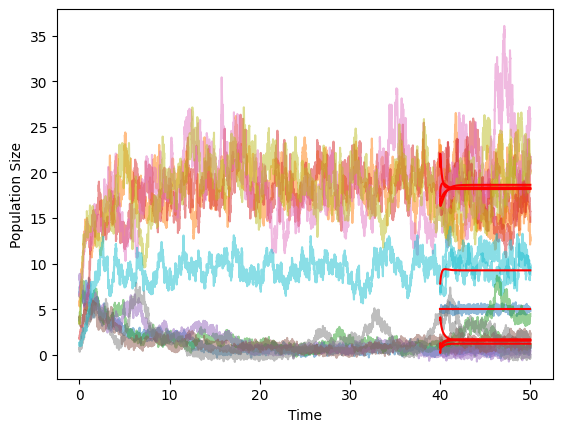

In [37]:
method_args =  dict(
    method_type=interfere.methods.VAR,
    method_params={},
    method_param_grid=None,
    num_intervention_sims=1,
    # Use parameters from a previous hyper parameter optimization.
    best_params = {'maxlags': 1, 'trend': 'c'}
)

intervention = params["intervention_type"](**params["intervention_params"])
X_do_preds, best_params = interfere.benchmarking.forecast_intervention(
    sample_X, sample_X_do, t, intervention, **method_args)

X_do_pred = X_do_preds[0]

plt.plot(t, sample_X, alpha=0.5)
plt.plot(t_future, sample_X_do, alpha=0.5)
plt.xlabel("Time")
plt.ylabel("Population Size")
plt.plot(t_future, X_do_pred, c="r", label="Prediction")
plt.show()

### Metrics

In [38]:
def mse(X, X_do, X_do_pred, intervened_idxs):
    """Compute mean squared error of prediction."""
    X_do_resp = np.delete(X_do, intervened_idxs)
    X_do_pred_resp = np.delete(X_do_pred, intervened_idxs)
    return np.mean((X_do_resp - X_do_pred_resp) ** 2)

    
rmsse = interfere.benchmarking.RootMeanStandardizedSquaredError()
ttest_acc = interfere.benchmarking.TTestDirectionalChangeAccuracy()

intervened_idxs = params["intervention_params"]["intervened_idxs"]
err0 = mse(sample_X, sample_X_do, X_do_pred, intervened_idxs)
err1 = rmsse(sample_X, sample_X_do, X_do_pred, intervened_idxs)
acc = ttest_acc(sample_X, sample_X_do, X_do_pred, intervened_idxs)
print(f"MSE: {err0} RMSSE: {err1} T-Test Prediction Acc: {acc}")


MSE: 7.836474537060106 RMSSE: 31.762241419541965 T-Test Prediction Acc: 0.1111111111111111


In [72]:
measurement_noise = np.logspace(-2, 0.5, 20)
system_noise = np.logspace(-2, 0.5, 20)

# Construct dictionary to hold results.
results_dict = {
    sigma: {
        mu: {"mse": [], "rmsse": [], "ttest_acc": []} 
        for mu in measurement_noise
    } 
    for sigma in system_noise
}

### Parameter sweep of different measurement noise and system noise values

In [74]:
intervention = params["intervention_type"](**params["intervention_params"])
intervened_idxs = params["intervention_params"]["intervened_idxs"]

# Iterate over every combination of noise parameter values.
for sigma in system_noise:
    for mu in measurement_noise:

        cur_params = deepcopy(params)
        cur_params["model_params"]["sigma"] = sigma
        cur_params["model_params"]["measurement_noise_std"] = mu * np.ones(dim)

        # Generate ground truth for various levels of noisiness.
        Xs, X_dos, t = interfere.generate_counterfactual_forecasts(**cur_params)

        # Make predictions for each time series
        for X, X_do in zip(Xs, X_dos):

            # Check for nans in simulation
            if not np.any(np.isnan(np.vstack([X, X_do]))):

                # Forecast the effect of the intervention
                X_do_preds, _ = interfere.benchmarking.forecast_intervention(
                    X, X_do, t, intervention, **method_args
                )
                X_do_pred = X_do_preds[0]

                # Check for nans in forecast.
                if not np.any(np.isnan(X_do_pred)):

                    # Measure error/accuracy and save.
                    results_dict[sigma][mu]["rmsse"].append(
                        rmsse(X, X_do, X_do_pred, intervened_idxs))
                    results_dict[sigma][mu]["mse"].append(
                        mse(X, X_do, X_do_pred, intervened_idxs))
                    results_dict[sigma][mu]["ttest_acc"].append(
                        ttest_acc(X, X_do, X_do_pred, intervened_idxs))

                # Record nans.
                else:
                    results_dict[sigma][mu]["rmsse"].append(np.nan)
                    results_dict[sigma][mu]["mse"].append(np.nan)
                    results_dict[sigma][mu]["ttest_acc"].append(np.nan)
            else:
                results_dict[sigma][mu]["rmsse"].append(np.nan)
                results_dict[sigma][mu]["mse"].append(np.nan)
                results_dict[sigma][mu]["ttest_acc"].append(np.nan)

            

/Users/djpassey/Code/interfere/interfere/dynamics/lotka_voltera.py:81: RuntimeWarning: overflow encountered in multiply
  return self.growth_rates * x * (
/Users/djpassey/Code/interfere/interfere/dynamics/lotka_voltera.py:82: RuntimeWarning: invalid value encountered in matmul
  1 -  (x + self.interaction_mat @ x) / self.capacities
/Users/djpassey/Code/interfere/interfere/dynamics/lotka_voltera.py:81: RuntimeWarning: overflow encountered in multiply
  return self.growth_rates * x * (
/Users/djpassey/Code/interfere/interfere/dynamics/lotka_voltera.py:82: RuntimeWarning: invalid value encountered in matmul
  1 -  (x + self.interaction_mat @ x) / self.capacities
/Users/djpassey/Code/interfere/interfere/dynamics/lotka_voltera.py:81: RuntimeWarning: overflow encountered in multiply
  return self.growth_rates * x * (
/Users/djpassey/Code/interfere/interfere/dynamics/lotka_voltera.py:82: RuntimeWarning: invalid value encountered in matmul
  1 -  (x + self.interaction_mat @ x) / self.capacitie

In [75]:
import pickle as pkl

with open("noise_and_forecast_error.pkl", "wb") as f:
    pkl.dump(results_dict, f)


## Analysis of Results

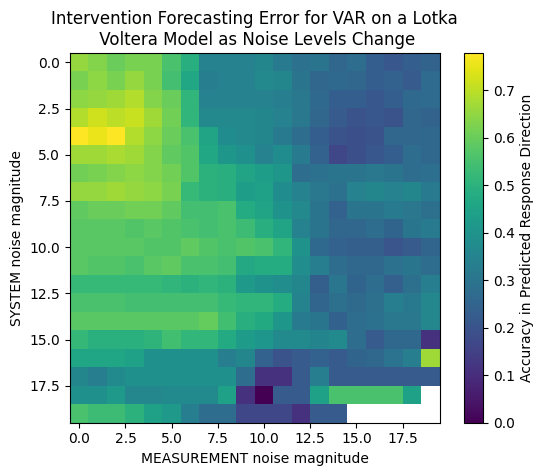

In [ ]:
ttest_acc_matrix = np.zeros((len(system_noise), len(measurement_noise)))

for i, sig in enumerate(system_noise):
    for j, mu in enumerate(measurement_noise):
        errs = np.array(results_dict[sig][mu]["ttest_acc"])
        errs = errs[~ np.isnan(errs)]
        ttest_acc_matrix[i, j] = np.mean(errs)


plt.imshow(ttest_acc_matrix)
plt.title("Intervention Forecasting Error for VAR on a Lotka"
          "\n Voltera Model as Noise Levels Change")
plt.xlabel("MEASUREMENT noise magnitude")
plt.ylabel("SYSTEM noise magnitude")
plt.colorbar(label="Accuracy in Predicted Response Direction")

Measuring accuracy of VAR's ability to predict the direction that each signal will change in
response to the intervention highlights the expected phenomenon:

That is, how initially, stochasticity increases the ability of the model to predict the intervention
response, but as the system becomes increasingly noisey, stochsticity becomes a
hinderance.

Measurement noise never offers any clear benefit and only serves to obscure the
true dynamics.

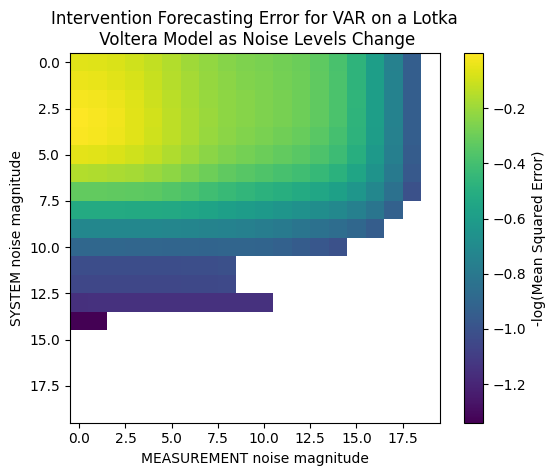

In [ ]:

mse_error_matrix = np.zeros((len(system_noise), len(measurement_noise)))

for i, sig in enumerate(system_noise):
    for j, mu in enumerate(measurement_noise):
        errs = np.array(results_dict[sig][mu]["mse"])
        #errs = errs[~ np.isnan(errs)]
        mse_error_matrix[i, j] = np.mean(errs)


plt.imshow(-np.log10(mse_error_matrix))
plt.title("Intervention Forecasting Error for VAR on a Lotka"
          "\n Voltera Model as Noise Levels Change")
plt.xlabel("MEASUREMENT noise magnitude")
plt.ylabel("SYSTEM noise magnitude")
plt.colorbar(label="-log(Mean Squared Error)")

This conclusion is confirmed by mean squared error of the intervention response
predictions which shows the same pattern of stochasticity reducing error
initially, but after a point, it causes an increase in error.

This pattern is more difficult to see, but with the help of the negative-log
transform we can observe that peak performance occurs in the same parameter
configuration as peak performance for the predicted response direction.

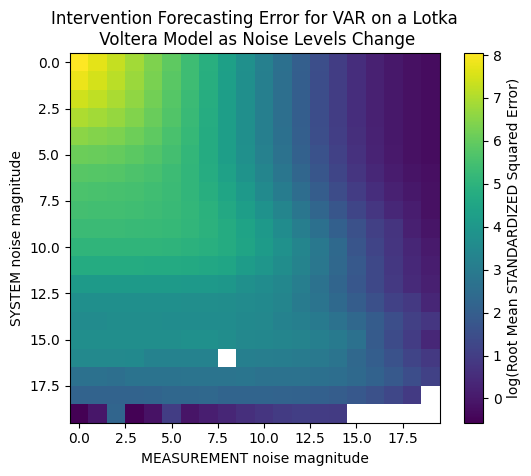

In [107]:

rmsse_error_matrix = np.zeros((len(system_noise), len(measurement_noise)))

for i, sig in enumerate(system_noise):
    for j, mu in enumerate(measurement_noise):
        errs = np.array(results_dict[sig][mu]["rmsse"])
        errs = errs[~ np.isnan(errs)]
        rmsse_error_matrix[i, j] = np.mean(errs)


plt.imshow(np.log(rmsse_error_matrix))
plt.title("Intervention Forecasting Error for VAR on a Lotka"
          "\n Voltera Model as Noise Levels Change")
plt.xlabel("MEASUREMENT noise magnitude")
plt.ylabel("SYSTEM noise magnitude")
plt.colorbar(label="log(Root Mean STANDARDIZED Squared Error)")

It is interesting to note that the pattern discussed above does not appear when
the forecast error is measured with mean standardized squared error. This metric shows that
stochastic and measurement noise unequivically decreases error as they
increase--which clearly is not the case.

This is the incorrect conclusion, and may derive from the way that as noise
increases, the variance in the response time series also increases. This leads
to a decrease in *relative* scaled error, but obscures the improvement that
occurs when stochasticity is first introduced to the system.